In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image

Matplotlib is building the font cache; this may take a moment.


# Record 1, 11.27.20, 20:57
>Ah sh1t, here we go again...

https://www.ncbi.nlm.nih.gov/sra TY2482 

Plasmids - extrachromosomal genetic elements; independent circular mini-chromosomes that co-exist with the bacterial genome

phages are shaped like lunar landers (Figure below), a design that helps them land on the cell wall of a bacterium and transmit their own genome (called a prophage) into the bacterial genome, so that when the bacterial DNA replicates, it creates new copies of the phage as well.


# 1. Assembling the genome
http://cab.spbu.ru/software/spades/ - from reads to contings

1 - forward
2 - reversed
### number of reads - via FastQC
SRR292678 - paired end, insert size 470 bp
* 1: 5499346
* 2: 5499346

SRR292862 – mate pair, insert size 2 kb
* 1: 5102041
* 2: 5102041

SRR292770 – mate pair, insert size 6 kb
* 1: 5102041
* 2: 5102041

Quality is good - almost all circles are green, except for GC-content in a couple of files

### k-mer distribution via Jellyfish

* -m: k-mer size
* -o: output file name
* -s: hash table size (should be larger than a genome. Genome of E.Coli is 4.6Mb
* -t: #of threads
* -C: both k-mer and its reverse complement count as the same
```bash
jellyfish count -m 31 -o kmer31 -s 5M -t 32 -C SRR292678sub_S1_L001_R1_001.fastq
jellyfish histo kmer31 > kmer31hist.txt  # make hist
```


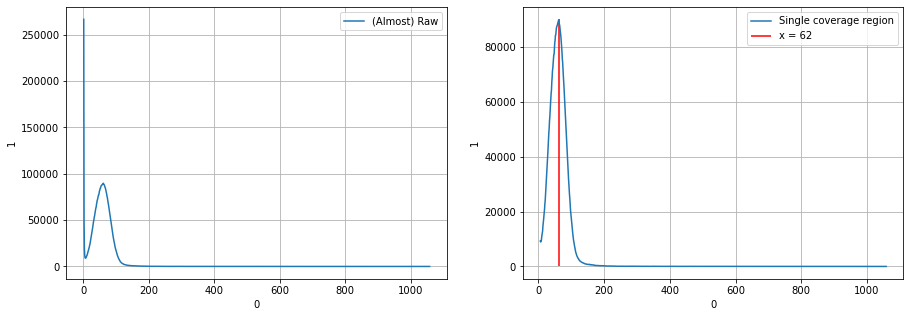

In [101]:
df = pd.read_csv('Data/kmer31hist.txt', sep=' ', header=None)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

actual = df[:][5:]
sns.lineplot(x=df[0][1:], y=df[1][1:], ax=axes[0], label='(Almost) Raw')
sns.lineplot(x=actual[0], y=actual[1], ax=axes[1], label='Single coverage region')
for ax in axes:
    ax.xaxis.grid()
    ax.yaxis.grid()
    
max_x = actual[0][np.argmax(actual[1])+5]
axes[1].vlines(max_x, 0, 90000, color='Red', label='x = ' + str(max_x))
plt.legend();

### estimate genome size

Following this: http://koke.asrc.kanazawa-u.ac.jp/HOWTO/kmer-genomesize.html

In [109]:
genome_estimate = (actual[0] * actual[1]).sum() / max_x 
int(genome_estimate)  # about 5.2Mb

5199855

## Assembling genome from paired reads via SPAdes
http://cab.spbu.ru/software/spades/

SPAdes go brrrr (paired end, SRR292678)
```bash
spades.py --pe1-1 SRR292678sub_S1_L001_R1_001.fastq --pe1-2 RR292678sub_S1_L001_R2_001.fastq -o assembly
```

# Record 2, 11.28.20 

Посмотрим что там собралось)

## Effect of the read correction
There're are a couple of archived .fasta files in 'corrected' folder. 
Redo k-mer distribution analisys on corrected forward reads:
```bash
jellyfish count -m 31 -o kmer31cor -s 5M -t 32 -C SRR292678sub_S1_L001_R1_001.00.0_0.cor.fastq
jellyfish histo kmer31cor > kmer31cor_hist.txt 
```

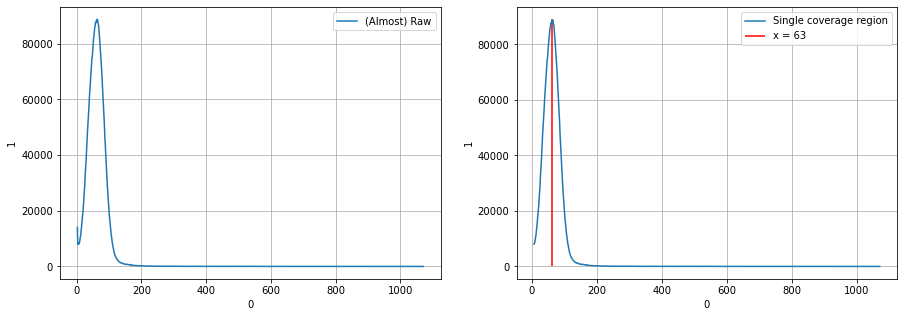

In [12]:
df = pd.read_csv('Data/assembly/corrected/kmer31cor_hist.txt', sep=' ', header=None)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

actual = df[:][5:]
sns.lineplot(x=df[0][1:], y=df[1][1:], ax=axes[0], label='(Almost) Raw')
sns.lineplot(x=actual[0], y=actual[1], ax=axes[1], label='Single coverage region')
for ax in axes:
    ax.xaxis.grid()
    ax.yaxis.grid()
    
max_x = actual[0][np.argmax(actual[1])+4]
axes[1].vlines(max_x, 0, 89000, color='Red', label='x = ' + str(max_x))
plt.legend();

## Running SPAdes with all libraries
SPAdes go brrr again:
```bash
spades.py --pe1-1 SRR292678sub_S1_L001_R1_001.fastq --pe1-2 SRR292678sub_S1_L001_R2_001.fastq --mp1-1 SRR292862_S2_L001_R1_001.fastq --mp1-2 SRR292862_S2_L001_R2_001.fastq --mp2-1 SRR292770_S1_L001_R1_001.fastq --mp2-2 SRR292770_S1_L001_R2_001.fastq -o assembly_full
```
Упал по памяти. 

Выделил виртуалке 7 гигов.

In [2]:
Image(url='https://sun9-61.userapi.com/impf/EUENTuHAHXgAfBaqaDDkpSftHKxluUNnldhUWQ/JKlrU2loOQU.jpg?size=1280x622&quality=96&sign=2af1fec1c03bb3703838d7ccbac6a845')

# Record 3, 11.30.20, 23:04

Скачал результаты

QUAST при попытке запустить плюётся исключениями. Использовал веб-интерфейс.

In [3]:
print('1 library')
display(Image(url='https://sun9-69.userapi.com/impg/5U3F98GfAfCqzxnWuOs29GKlAj5_jpKF6RxvUQ/x_EJCF_hRgw.jpg?size=493x494&quality=96&proxy=1&sign=57190217be0524d95dc12d755b11bab6'))
print('3 libraries')
display(Image(url='https://sun9-70.userapi.com/impg/LSHdCk-rIr-H-uD_UyTPeC8IKcRxfR_isIrxAQ/SVcBFkhaPUg.jpg?size=490x497&quality=96&proxy=1&sign=c4f2031edb43ca5065238b4e13e06c37'))


1 library


3 libraries


N50 подрос, хехе

## 2. Annotation - prokka

тоже не пошло. 
Can't locate XML/Simple.pm in @INC (you may need to install the XML::Simple module) (@INC contains: /home/iam28th/anaconda3/lib/site_perl/5.26.2/x86_64-linux-thread-multi /home/iam28th/anaconda3/lib/site_perl/5.26.2 /home/iam28th/anaconda3/lib/5.26.2/x86_64-linux-thread-multi /home/iam28th/anaconda3/lib/5.26.2 .) at /home/iam28th/anaconda3/bin/prokka line 25.
BEGIN failed--compilation aborted at /home/iam28th/anaconda3/bin/prokka line 25.

-- то была попытка (попытки) поставить через конду. Обнаружить XML::Simple так и не вышло. Судя по всему прокка смотрит на какой-то другой перл.


В итоге вроде бы поставилось по инструкции для Ubuntu/Debian/Mint 

Итак, `prokka go brrrr`.
```bash
[14:18:45] Contig ID must <= 37 chars long: NODE_1_length_2815616_cov_74.3819_ID_564387
[14:18:45] Please rename your contigs OR try '--centre X --compliant' to generate clean contig names.
```
Окей
```bash
prokka scaffolds.fasta --force --centre X --compliant
```
exception!
```bash
Bio::SearchIO: hmmer3 cannot be found
Exception 
------------- EXCEPTION: Bio::Root::Exception -------------
MSG: Failed to load module Bio::SearchIO::hmmer3. Can't locate Bio/SearchIO/hmmer3.pm in @INC (you may need to install the Bio::SearchIO::hmmer3 module) (@INC contains: /etc/perl /usr/local/lib/x86_64-linux-gnu/perl/5.30.0 /usr/local/share/perl/5.30.0 /usr/lib/x86_64-linux-gnu/perl5/5.30 /usr/share/perl5 /usr/lib/x86_64-linux-gnu/perl/5.30 /usr/share/perl/5.30 /usr/local/lib/site_perl /usr/lib/x86_64-linux-gnu/perl-base) at /usr/share/perl5/Bio/Root/Root.pm line 520.
```
Установил его через `sudo cpan Bio::SearchIO::hmmer3`

In [2]:
Image(url='https://sun9-62.userapi.com/impf/xEYWGYbdrBv3-1uGGx2CkSrG6TrxGMczWJgAxA/hj6Wxg9rhP8.jpg?size=1203x577&quality=96&proxy=1&sign=59f44e0ec9c66fc39d936887001e725e')

Не зря ставил)

Файла .gbf в папке нет (впрочем, в скаченной папке с аутпутом его тоже нет). UPD походу имели в виду .gbk

# 3. Finding closest relative - barrnap
barrnap, v 0.9

```bash
barrnap scaffolds.fasta > barrnap_ribosome_search
```
Вытащить оттуда S16:

In [8]:
%cd assembly_ful
%ls

/home/iam28th/Notebooks/IB_1/Project3/Data/assembly_ful
barrnap_ribosome_search  contigs.fasta     scaffolds.fasta      spades.log
barr_out.txt             PROKKA_12012020/  scaffolds.fasta.fai


In [12]:
with open('barrnap_ribosome_search', 'r') as f:
    s = f.read()
s.split('\n>')[0].split('\n')[1] == s.split('\n>')[1].split('\n')[1]   
## первые две последовательности, которые (предположительно) на самом длинном контиге, идентичны

True

In [17]:
r16s = s.split('\n>')[0].split('\n')[1]
r16s

'TTGAAGAGTTTGATCATGGCTCAGATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAACGGTAACAGGAAACAGCTTGCTGTTTCGCTGACGAGTGGCGGACGGGTGAGTAATGTCTGGGAAACTGCCTGATGGAGGGGGATAACTACTGGAAACGGTAGCTAATACCGCATAACGTCGCAAGACCAAAGAGGGGGACCTTCGGGCCTCTTGCCATCGGATGTGCCCAGATGGGATTAGCTTGTTGGTGGGGTAACGGCTCACCAAGGCGACGATCCCTAGCTGGTCTGAGAGGATGACCAGCCACACTGGAACTGAGACACGGTCCAGACTCCTACGGGAGGCAGCAGTGGGGAATATTGCACAATGGGCGCAAGCCTGATGCAGCCATGCCGCGTGTATGAAGAAGGCCTTCGGGTTGTAAAGTACTTTCAGCGGGGAGGAAGGGAGTAAAGTTAATACCTTTGCTCATTGACGTTACCCGCAGAAGAAGCACCGGCTAACTCCGTGCCAGCAGCCGCGGTAATACGGAGGGTGCAAGCGTTAATCGGAATTACTGGGCGTAAAGCGCACGCAGGCGGTTTGTTAAGTCAGATGTGAAATCCCCGGGCTCAACCTGGGAACTGCATCTGATACTGGCAAGCTTGAGTCTCGTAGAGGGGGGTAGAATTCCAGGTGTAGCGGTGAAATGCGTAGAGATCTGGAGGAATACCGGTGGCGAAGGCGGCCCCCTGGACGAAGACTGACGCTCAGGTGCGAAAGCGTGGGGAGCAAACAGGATTAGATACCCTGGTAGTCCACGCCGTAAACGATGTCGACTTGGAGGTTGTGCCCTTGAGGCGTGGCTTCCGGAGCTAACGCGTTAAGTCGACCGCCTGGGGAGTACGGCCGCAAGGTTAAAACTCAAATGAATTGACGGGGGCCCGCACAAGCGGTGGAGCATGTGGTTTAATTCGATGCAACGCGAAGAACCTTACCTGGTCTTGACATCCACG

In [23]:
with open('r16s.txt', 'w') as f:
    f.write('>r16S\n' + r16s)

### Blast



In [26]:
print('Только ещё подписал организм E. Coli')
Image(url='https://sun9-25.userapi.com/impg/XD3LrucFNdyMMIwaTgji7chochEDNy-uVL8Htw/st-ht6I_mwY.jpg?size=1024x807&quality=96&proxy=1&sign=bd9047edd1d71ead78656d43efd7d0f5', width=500)

Только ещё подписал организм E. Coli


https://www.ncbi.nlm.nih.gov/nucleotide/NC_011748.1?report=genbank&log$=nuclalign&blast_rank=1&RID=WCDZAZ61013

100% совпадение. NC_011748.1 Escherichia coli 55989, complete genome

Оригинальная статья про этот геном:
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC120615/

In [48]:
Image(url='https://sun9-6.userapi.com/impf/C4_Nk-qpSSBEP7nHXJFhkeNNUfQAcqLUXjS-Uw/l__jeM0N94w.jpg?size=184x87&quality=96&proxy=1&sign=ba4a178d7a3fc98aca570749b9817f6c')

# 4. Genome Alignment - Mauve

Shiga toxins encoding genes:
* stxB 3483605 - 3483874; length: 270
* stxA 3483886 - 3484845; length: 960

In [53]:
Image(url='https://sun9-8.userapi.com/impg/n9HYN4gLE0GtlXsv9zAEOIlgCj--ssJi6W4QRw/Af-Jz9T5a6c.jpg?size=808x708&quality=96&proxy=1&sign=423283f747c598a9033ec084d28cb5f9')

Lots of hypothetical protein

https://rast.nmpdr.org/ - another tool for annotation

а-ХА! Там повсюду белки фагов! С обеих сторон!

# 5. Antibiotic resistance detection

https://cge.cbs.dtu.dk/services/ResFinder/

https://cge.cbs.dtu.dk//cgi-bin/webface.fcgi?jobid=5FC65C6B0000553C68EDE74B - results for E.Coli X (hope the link won't expire tomorrow)

Скачал ещё текстовые версии табличек (файлы pheno_type*.txt)

In [58]:
print('E.Coli X')
display(Image(url='https://sun9-15.userapi.com/impg/LWcfCoMtIgtgfF-6l6GtM8gtsRuQPxjVd47LzQ/erVMQBnV_8o.jpg?size=1123x794&quality=96&proxy=1&sign=cfd2e9be9917aef5066e71db4f5d1c41',
             width=800))
print('Reference')
display(Image(url='https://sun9-17.userapi.com/impg/cXHLgOoj3YIIOiqTLldcvA65x2Z7cFe31k7n3w/gN_74AxLcMA.jpg?size=1118x806&quality=96&proxy=1&sign=efd35ed984bdbe8eb371737747ec649e',
             width=800))

E.Coli X


Reference


### Search for beta-lactamase

Есть 4 участка, кодирующих бета-лактамазу. Окинул беглым взглядом, что их окружает

1. 2715586 - 2716878 - минимум один гипотетический протеин слева
2. 3118335 - 3119468 - аналогично предыдущему
3. 5119164 - 5120024 - рядом есть всякие Mobile element и Phage replication protein-ы
4. 5376443 - 5377318 - рядом есть гипотетические протеины и всякие белки фазмид

